In [1]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import community

from sklearn import preprocessing
from itertools import count

from project_utils import attrs_to_graph, gefx_compatible

%reload_ext autoreload
%autoreload 2

sns.set()

# Analysis of the attributes

In [2]:
actors_agg_adj = np.load("sparse_agg_actor_adj.npy")
actors_agg_df = pd.read_pickle("actors_agg_df.pkl")
actors_graph = nx.from_numpy_matrix(actors_agg_adj)

In [3]:
# Change gender
actors_agg_df["gender"] = actors_agg_df["gender"].map(lambda x: "F" if x == 1 else "M")

In [4]:
# Add name and gender as node attribute
name_dict = {}
gender_dict = {}
attributes = actors_agg_df[['actors', 'gender']].values
for index, attr in enumerate(attributes):
    name_dict[index] = attr[0]
    gender_dict[index] = attr[1]
nx.set_node_attributes(actors_graph, name_dict, 'name')
nx.set_node_attributes(actors_graph, gender_dict, 'gender')

In [5]:
# Add eigenvector centrality as node attribute
eigenvector_dict = nx.eigenvector_centrality(actors_graph)
nx.set_node_attributes(actors_graph, eigenvector_dict, 'eigenvector')

In [6]:
seed = 30
# Create communities using community detection library
communities_dict = community.best_partition(actors_graph, random_state = seed)
# Add community as attribute
nx.set_node_attributes(actors_graph, communities_dict, 'community')

In [7]:
# Extract communities to an array of objects
communities = []
for i in range(max(communities_dict.values()) + 1):
    communities.append([actors_graph.node[n] for n in actors_graph.nodes() if actors_graph.node[n]['community'] == i])

In [8]:
# Extract communities to an array of objects
communities = []
for i in range(max(communities_dict.values()) + 1):
    communities.append([actors_graph.node[n] for n in actors_graph.nodes() if actors_graph.node[n]['community'] == i])

In [9]:
# Create dataframe from extracted communities 
communities_df = [pd.DataFrame(n) for n in communities]
naive_communities_df = communities_df

In [10]:
# Find representatives of each class by eigenvector centrality
for index, community in enumerate(communities_df):
    print(f'Representatives of community {index} with a size of {len(community.index)} actors\n{community.nlargest(10, "eigenvector")}\n')

Representatives of community 0 with a size of 835 actors
                name gender  eigenvector  community
462       Loren Dean      M     0.030552          0
525     Mekhi Phifer      M     0.030534          0
48     Annabeth Gish      F     0.028134          0
685  Samantha Mathis      F     0.028000          0
150    D. B. Sweeney      M     0.027244          0
268    Gregory Smith      M     0.026938          0
99    Brooke Shields      F     0.024650          0
172     David Caruso      M     0.023269          0
174      David Keith      M     0.023267          0
15      Aimee Garcia      F     0.022856          0

Representatives of community 1 with a size of 526 actors
                 name gender  eigenvector  community
156    Frank Langella      M     0.043506          1
211  James Gandolfini      M     0.043262          1
106    Dakota Fanning      F     0.042612          1
381      Nicolas Cage      M     0.042459          1
95       Claire Danes      F     0.042313       

We can observe that in community 2 we have notable A-list actors while in the smallest one (community 7) we have celebrities who might have participated in some movies but are not really actors.

# Visualization

/Users/arielalba/anaconda3/envs/network-tour/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


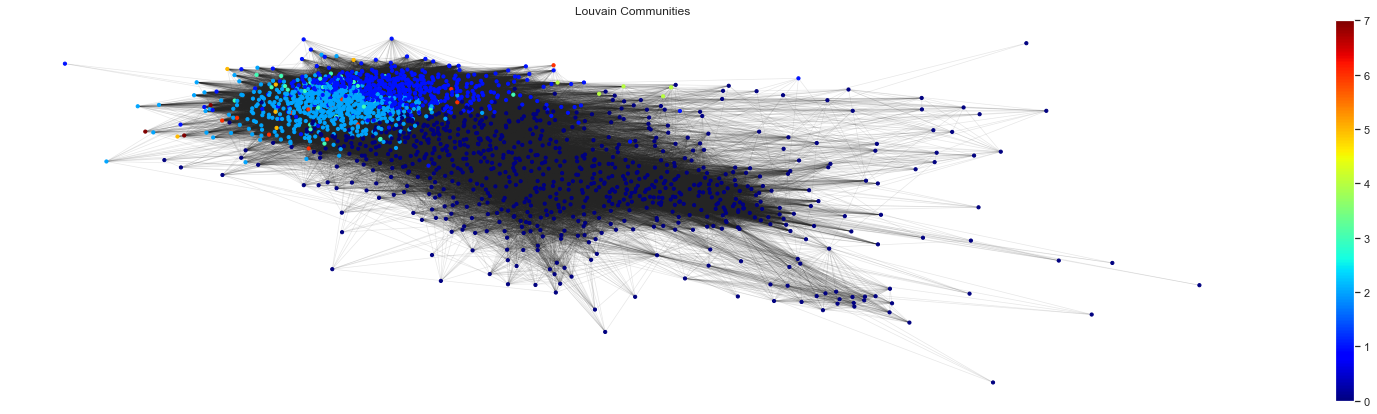

In [11]:
# Visualize with colors per community
groups = set(nx.get_node_attributes(actors_graph,'community').values())
mapping = dict(zip(sorted(groups),count()))
nodes = actors_graph.nodes()
colors = [mapping[actors_graph.node[n]['community']] for n in nodes]

# Drawing nodes and edges separately to add colors
plt.figure(figsize=(28, 7))
pos = nx.spring_layout(actors_graph)
ec = nx.draw_networkx_edges(actors_graph, pos, alpha=0.1, width=0.7)
nc = nx.draw_networkx_nodes(actors_graph, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=10, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.title("Louvain Communities")
plt.savefig("plots/louvain.pdf")
plt.show()

We can observe that community 2 (the famous A-list actors) tend to work together more often, and also with a selection of actors from other communities. Some mid-tier actors are popular and mix with many other communities, while some are stuck in their own community. The celebrities who are not really actors (community 7) are very separated from other actors communities.

# Explain communities with logistic regression on signals

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
actors_id_df = actors_agg_df[["actors"]].reset_index()
actors_id_df.head()

,actor_id,actors
0,0,"""Weird Al"" Yankovic"
1,1,50 Cent
2,2,AJ Michalka
3,3,Aamir Khan
4,4,Aaron Abrams


In [14]:
communities_df = pd.concat(communities_df).drop(columns=["gender","eigenvector"])
print(len(communities_df))
communities_df.head()

1971


,name,community
0,"""Weird Al"" Yankovic",0
1,AJ Michalka,0
2,Aamir Khan,0
3,Aaron Kwok,0
4,Aasheekaa Bathija,0


In [15]:
community_labels_df = communities_df.merge(actors_id_df,left_on="name",right_on="actors").drop(columns=["name"]).set_index("actor_id")
print(np.unique(community_labels_df.index))
print(len(np.unique(community_labels_df.index)))
community_labels_df.head()


[   0    1    2 ... 1968 1969 1970]
1971


,community,actors
actor_id,,
0,0,"""Weird Al"" Yankovic"
2,0,AJ Michalka
3,0,Aamir Khan
6,0,Aaron Kwok
10,0,Aasheekaa Bathija


In [16]:
community_labels_df=community_labels_df.drop(columns=["actors"])
community_labels_df.head()

,community
actor_id,
0,0
2,0
3,0
6,0
10,0


In [17]:
actors_dataset_df = actors_agg_df.join(community_labels_df)[["budget","popularity","revenue","vote_average","vote_count","community"]]
# Save .npy file to use later
actors_with_communities_dataset = actors_dataset_df.to_numpy()
np.save("actors_with_communities_dataset", actors_with_communities_dataset)
actors_dataset_df.head()

,budget,popularity,revenue,vote_average,vote_count,community
actor_id,,,,,,
0,17000000.0,14.215532,2.263852e+07,5.750,256.000,0
1,36652500.0,30.167837,9.993918e+07,6.175,772.625,1
2,37500000.0,19.503003,1.034682e+08,6.500,906.750,0
3,1100000.0,3.226925,6.015562e+06,6.900,53.000,0
4,33250000.0,21.136737,6.390146e+07,6.250,631.750,1


### Save dataset with communities

In [18]:
actors_dataset_df.to_pickle("actors_dataset_df.pkl")

In [19]:
actors_dataset = actors_dataset_df.values
X = actors_dataset[:,1:-1]
y = actors_dataset[:,-1]
train_features,test_features,train_labels,test_labels=train_test_split(X,y,test_size=0.2)

In [20]:
# Fit a logistic regression model
max_iter = 10000000
std_scaler = StandardScaler()
scaled_train_features = std_scaler.fit_transform(train_features)
model = LogisticRegression(
    solver="liblinear", multi_class="auto", max_iter=max_iter, C=10000
)
model.fit(scaled_train_features, train_labels)
scaled_test_features = std_scaler.transform(test_features)
predict_train = model.predict(scaled_train_features)
predict_test = model.predict(scaled_test_features)

In [21]:
accuracy=accuracy_score(test_labels,predict_test)
print("Accuracy: " +str(accuracy))

Accuracy: 0.5265822784810127


# Boxplots of signals on communities

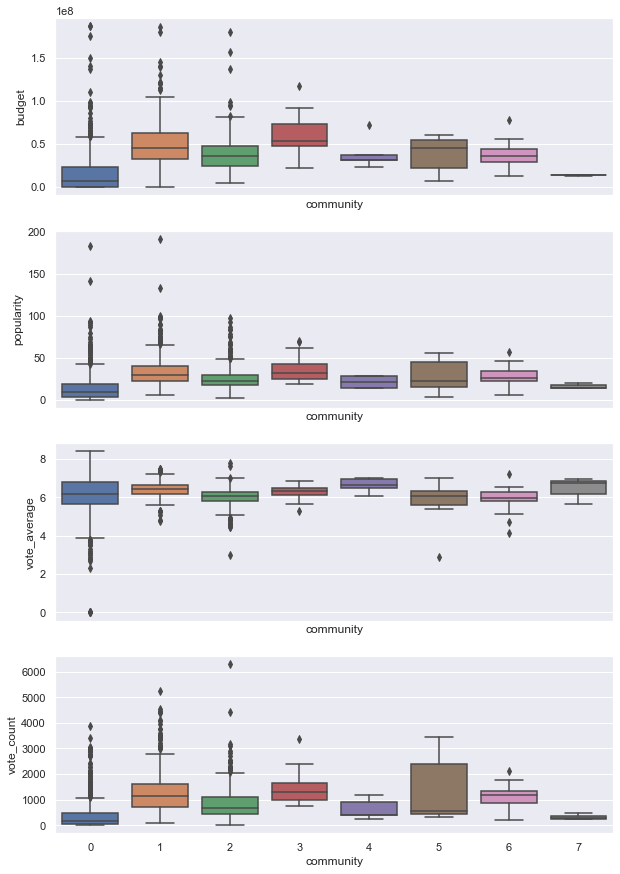

In [22]:
signals = ["budget","popularity","vote_average","vote_count"]
f, axes = plt.subplots(4,1,figsize=(10,15),sharex= True)
for i, signal in enumerate(signals):
    sns.boxplot(x="community", y=signal, data=actors_dataset_df, ax=axes[i]);
    # Uncomment if you want to see every point
    # sns.swarmplot(x="community", y=signal, data=actors_dataset_df, color=".25", ax=axes[i]);
plt.savefig("plots/communities_boxplots.pdf")


# Save for Gephi

In [23]:
# Add name and gender as node attribute
columns_of_type_set = ["cast", "crew", "movie_id", "genres", "keywords", 
                       "original_language", "production_companies", 
                       "production_countries", "spoken_languages", "title",
                       "release_date", "status"]

for col in columns_of_type_set:
    actors_agg_df[col] = actors_agg_df[col].map(gefx_compatible)

actors_agg_df["id"] = actors_agg_df["actors"]
actors_agg_df["name"] = ""

# update names for the most important actors of each community
for index, community in enumerate(naive_communities_df):
    names = community.nlargest(10, "eigenvector")["name"]
    actors_agg_df.loc[actors_agg_df["actors"].isin(names), "name"] = actors_agg_df.loc[actors_agg_df["actors"].isin(names), "actors"]

cols_to_gefx = ["id", "name", "gender", "budget", "genres", "popularity", "revenue", "spoken_languages", "vote_average", "vote_count"]
attrs_to_graph(actors_graph, actors_agg_df[cols_to_gefx])

for index, community in enumerate(naive_communities_df):
    names = community.nlargest(10, "eigenvector")["name"]
    names_dict = actors_agg_df.loc[actors_agg_df["actors"].isin(names), "actors"].to_dict()
    actors_graph = nx.relabel_nodes(actors_graph, names_dict)


In [24]:
# write in gefx format
DATA_PATH = "data"
nx.write_gexf(actors_graph, f"{DATA_PATH}/louvain_graph.gexf")